# Optional Lab: Gradient Descent for Linear Regression

![](./images/lecture-gradient-descent.png)


## Goals

In this lab, you will:

- automate the process of optimizing $w$ and $b$ using gradient descent.

## Tools

In this lab, we will make use of:

- `numPy`, a popular library for scientific computing
- `matplotlib`, a popular library for plotting data
- plotting routines in the `lab_utils.py` file in the local director

In [17]:
import math, copy
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('./deeplearning.mplstyle')
from lab_utils_uni import plt_house_x, plt_contour_wgrad, plt_divergence, plt_gradients

## Problem Statement

Let's use the same two data points as before - a house with 1000 square feet sold for \\$300,000 and a house with 2000 square feet sold for \\$500,000.

|Size (100 sqft)|Price (1000s \\$)|
|:-|:-|
|1|300|
|2|500|

In [18]:
x_train = np.array([1.0, 2.0])
y_train = np.array([300.0, 500.0])


## Compute_Cost

This was developed in the last lab. We'll need it again here.

In [19]:
#Function to calculate the cost

def compute_cost(x, y, w, b):
    """
    """
    m = x.shape[0]
    cost = 0
    
    for i in range(m):
        cost = cost + ((w*x[i] + b) - y[i])**2
    total_cost = 1 / (2 * m) * cost
    
    return total_cost


## Gradient descent summary

So far in this course, you have developed a linear model that predicts $f_{w,b}(x^{(i)})$:

$f_{w,b}(x^{(i)}) = wx^{(i)} + b\tag{1}$

In linear regression, you utilize input training data to fit the parameters $w,b$ by minimizing a measure of the error between our predictions $f_{w,b}(x^{(i)})$ and the actual data $y^{(i)}$. The measure is called the $cost, J(w,b)$. In training you measure the cost over all of our training samples $x^{(i)},y^{(i)}$

$J(w,b) = \frac{1}{2m} \sum\limits_{i = 0}^{m-1} (f_{w,b}(x^{(i)}) - y^{(i)})^2\tag{2}$

In lecture, gradient descent was described as:

$\begin{align*} \text{repeat}&\text{ until convergence:} \; \lbrace \newline
\;  w &= w -  \alpha \frac{\partial J(w,b)}{\partial w} \tag{3}  \; \newline 
 b &= b -  \alpha \frac{\partial J(w,b)}{\partial b}  \newline \rbrace
\end{align*}$

where, parameters $w,b$ are updated simultaneously.
The gradient is defined as:

$\begin{align}
\frac{\partial J(w,b)}{\partial w}  &= \frac{1}{m} \sum\limits_{i = 0}^{m-1} (f_{w,b}(x^{(i)}) - y^{(i)})x^{(i)} \tag{4}\\
  \frac{\partial J(w,b)}{\partial b}  &= \frac{1}{m} \sum\limits_{i = 0}^{m-1} (f_{w,b}(x^{(i)}) - y^{(i)}) \tag{5}\\
\end{align}$

Here *simultaniously* means that you calculate the partial derivatives for all the parameters before updating any of the parameters.


## Implement Gradient Descent

You will implement gradient descent algorithm for one feature. You will need three functions.

- `compute_gradient` implementing equation (4) and (5) above
- `compute_cost` implementing equation (2) above (code from previous lab)
- `gradient_descent`, utilizing `compute_gradient` and `compute_cost`

Conventions:

- The naming of python variables containing partial derivatives follows this pattern, $\frac{\partial J(w,b)}{\partial b}$ will be `dj_db`.
- w.r.t is With Respect To, as in partial derivative $J(w,b)$ of With Respect To $b$.

## compute_gradient

`compute_gradient` implements (4) and (5) above and returns $\frac{\partial J(w,b)}{\partial w}$,$\frac{\partial J(w,b)}{\partial b}$. The embedded comments describe the operations.

In [26]:
def compute_gradient(x, y, w, b): 
    """
    Computes the gradient for linear regression 
    Args:
      x (ndarray (m,)): Data, m examples 
      y (ndarray (m,)): target values
      w,b (scalar)    : model parameters  
    Returns
      dj_dw (scalar): The gradient of the cost w.r.t. the parameters w
      dj_db (scalar): The gradient of the cost w.r.t. the parameter b     
     """
    
    m = x.shape[0]
    dj_dw, dj_db = 0, 0
    
    for i in range(m):
        dj_dw += ((w * x[i] + b) - y[i]) * x[i]
        dj_db += ((w * x[i] + b) - y[i])
    dj_dw = dj_dw/m
    dj_db = dj_db/m
    
    return dj_dw, dj_db

![Slopes](./images/lecture-slopes.png "Slopes")

The lectures described how gradient descent utilizes the partial derivative of the cost with respect to a parameter at a point to update that parameter.
Let's use our `compute_gradient` function to find and plot some partial derivatives of our cost function relative to one of the parameters,
.

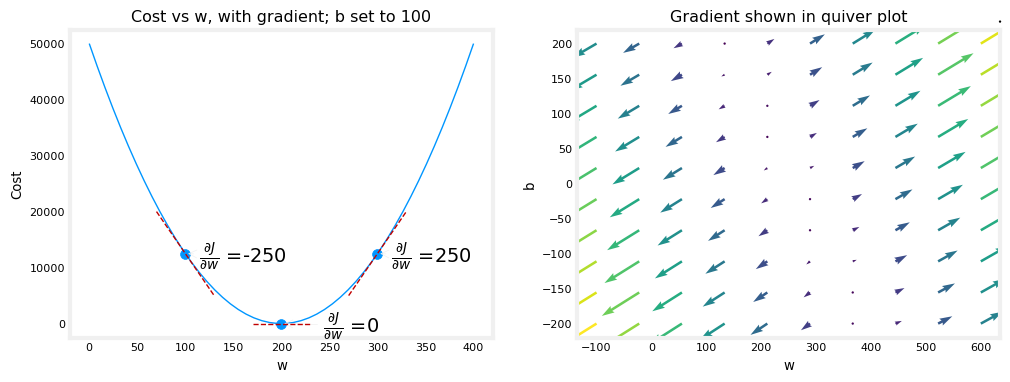

In [30]:
plt_gradients(x_train,y_train, compute_cost, compute_gradient)
plt.show()

Above, the left plot shows $\frac{\partial J(w,b)}{\partial w}$ or the slope of the cost curve relative to $w$ at three points. On the right side of the plot, the derivative is positive, while on the left it is negative. Due to the 'bowl shape', the derivatives will always lead gradient descent toward the bottom where the gradient is zero.

The left plot has fixed $b = 100$. Gradient descent will utilize both $\frac{\partial J(w,b)}{\partial w}$ and $\frac{\partial J(w,b)}{\partial b}$ to update parameters. The 'quiver plot' on the right provides a means of viewing the gradient of both parameters. The arrow sizes reflect the magnitude of the gradient at that point. The direction and slope of the arrow reflects the ratio of $\frac{\partial J(w,b)}{\partial w}$ and $\frac{\partial J(w,b)}{\partial b}$ at that point. Note that the gradient points *away* from the minimum. Review equation (3) above. The scaled gradient is subtracted from the current value of $w$ or $b$ . This moves the parameter in a direction that will reduce cost.

## Gradient Descent

Now that gradients can be computed, gradient descent, described in equation (3) above can be implemented below in `gradient_descent`. The details of the implementation are described in the comments. Below, you will utilize this function to find optimal values of $w$ and $b$ on the training data.

In [34]:
def gradient_descent(x, y, w_in, b_in, alpha, num_iters, cost_function, gradient_function): 
    """
    Performs gradient descent to fit w,b. Updates w,b by taking 
    num_iters gradient steps with learning rate alpha
    
    Args:
      x (ndarray (m,))  : Data, m examples 
      y (ndarray (m,))  : target values
      w_in,b_in (scalar): initial values of model parameters  
      alpha (float):     Learning rate
      num_iters (int):   number of iterations to run gradient descent
      cost_function:     function to call to produce cost
      gradient_function: function to call to produce gradient
      
    Returns:
      w (scalar): Updated value of parameter after running gradient descent
      b (scalar): Updated value of parameter after running gradient descent
      J_history (List): History of cost values
      p_history (list): History of parameters [w,b] 
      """
    w = copy.deepcopy(w_in) # avoid modifying global w_in
    # An array to store cost J and w's at each iteration primarily for graphing later
    J_history = []
    p_history = []
    b = b_in
    w = w_in
    
    for i in range(num_iters):
        # Calculate the gradient and update the parameters using gradient_function
        dj_dw, dj_db = gradient_function(x, y, w , b)     

        # Update Parameters using equation (3) above
        b = b - alpha * dj_db                            
        w = w - alpha * dj_dw                            

        # Save cost J at each iteration
        if i<100000:      # prevent resource exhaustion 
            J_history.append( cost_function(x, y, w , b))
            p_history.append([w,b])
        # Print cost every at intervals 10 times or as many iterations if < 10
        if i% math.ceil(num_iters/10) == 0:
            print(f"Iteration {i:4}: Cost {J_history[-1]:0.2e} ",
                  f"dj_dw: {dj_dw: 0.3e}, dj_db: {dj_db: 0.3e}  ",
                  f"w: {w: 0.3e}, b:{b: 0.5e}")
 
    return w, b, J_history, p_history #return w and J,w history for graphing

In [40]:
# initialize parameters
w_init = 0
b_init = 0
# some gradient descent settings
iterations = 10000
tmp_alpha = 1.0e-2
# run gradient descent
w_final, b_final, J_hist, p_hist = gradient_descent(x_train ,y_train, w_init, b_init, tmp_alpha, 
                                                    iterations, compute_cost, compute_gradient)
print(f"(w,b) found by gradient descent: ({w_final:8.4f},{b_final:8.4f})")

Iteration    0: Cost 7.93e+04  dj_dw: -6.500e+02, dj_db: -4.000e+02   w:  6.500e+00, b: 4.00000e+00
Iteration 1000: Cost 3.41e+00  dj_dw: -3.712e-01, dj_db:  6.007e-01   w:  1.949e+02, b: 1.08228e+02
Iteration 2000: Cost 7.93e-01  dj_dw: -1.789e-01, dj_db:  2.895e-01   w:  1.975e+02, b: 1.03966e+02
Iteration 3000: Cost 1.84e-01  dj_dw: -8.625e-02, dj_db:  1.396e-01   w:  1.988e+02, b: 1.01912e+02
Iteration 4000: Cost 4.28e-02  dj_dw: -4.158e-02, dj_db:  6.727e-02   w:  1.994e+02, b: 1.00922e+02
Iteration 5000: Cost 9.95e-03  dj_dw: -2.004e-02, dj_db:  3.243e-02   w:  1.997e+02, b: 1.00444e+02
Iteration 6000: Cost 2.31e-03  dj_dw: -9.660e-03, dj_db:  1.563e-02   w:  1.999e+02, b: 1.00214e+02
Iteration 7000: Cost 5.37e-04  dj_dw: -4.657e-03, dj_db:  7.535e-03   w:  1.999e+02, b: 1.00103e+02
Iteration 8000: Cost 1.25e-04  dj_dw: -2.245e-03, dj_db:  3.632e-03   w:  2.000e+02, b: 1.00050e+02
Iteration 9000: Cost 2.90e-05  dj_dw: -1.082e-03, dj_db:  1.751e-03   w:  2.000e+02, b: 1.00024e+02


Take a moment and note some characteristics of the gradient descent process printed above.

- The cost starts large and rapidly declines as described in the slide from the lecture.
- The partial derivatives, `dj_dw`, and `dj_db` also get smaller, rapidly at first and then more slowly. As shown in the diagram from the lecture, as the process nears the 'bottom of the bowl' progress is slower due to the smaller value of the derivative at that point.
- progress slows though the learning rate, alpha, remains fixed



## Cost versus iterations of gradient descent

A plot of cost versus iterations is a useful measure of progress in gradient descent. Cost should always decrease in successful runs. The change in cost is so rapid initially, it is useful to plot the initial decent on a different scale than the final descent. In the plots below, note the scale of cost on the axes and the iteration step.


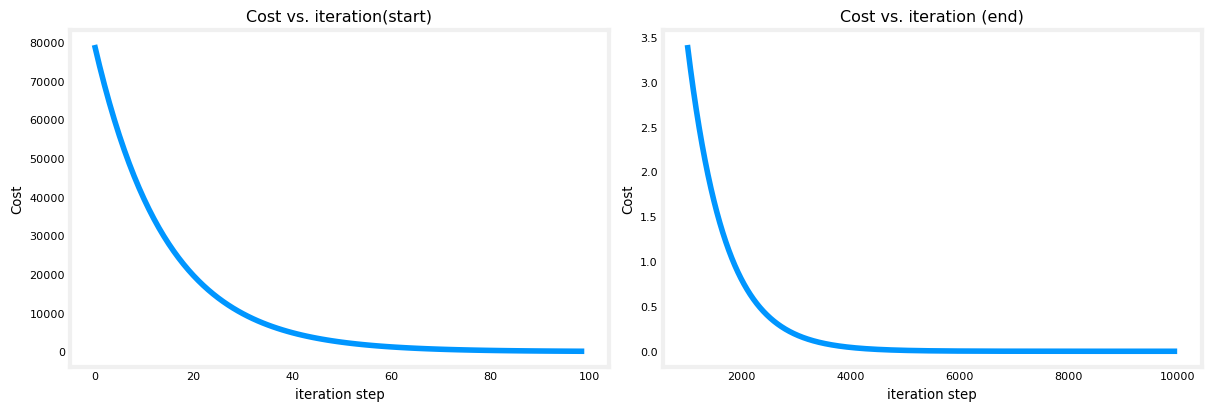

In [44]:
# plot cost versus iteration  
fig, (ax1, ax2) = plt.subplots(1, 2, constrained_layout=True, figsize=(12,4))
ax1.plot(J_hist[:100])
ax2.plot(1000 + np.arange(len(J_hist[1000:])), J_hist[1000:])
ax1.set_title("Cost vs. iteration(start)");  ax2.set_title("Cost vs. iteration (end)")
ax1.set_ylabel('Cost')            ;  ax2.set_ylabel('Cost') 
ax1.set_xlabel('iteration step')  ;  ax2.set_xlabel('iteration step') 
plt.show()


## Predictions

Now that you have discovered the optimal values for the parameters $w$ and $b$, you can now use the model to predict housing values based on our learned parameters. As expected, the predicted values are nearly the same as the training values for the same housing. Further, the value not in the prediction is in line with the expected value.

In [45]:
print(f"1000 sqft house prediction {w_final*1.0 + b_final:0.1f} Thousand dollars")
print(f"1200 sqft house prediction {w_final*1.2 + b_final:0.1f} Thousand dollars")
print(f"2000 sqft house prediction {w_final*2.0 + b_final:0.1f} Thousand dollars")

1000 sqft house prediction 300.0 Thousand dollars
1200 sqft house prediction 340.0 Thousand dollars
2000 sqft house prediction 500.0 Thousand dollars



## Plotting

You can show the progress of gradient descent during its execution by plotting the cost over iterations on a contour plot of the cost(w,b).

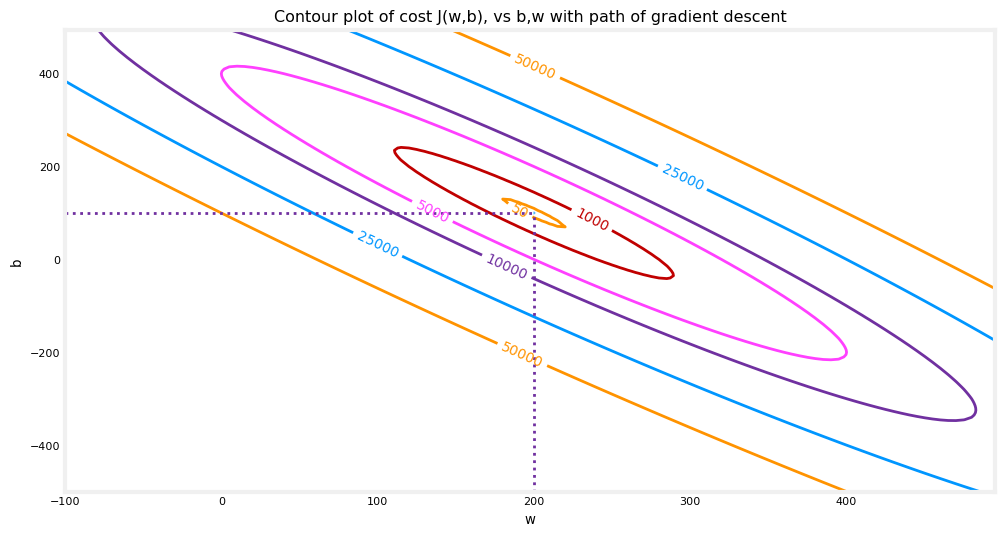

In [54]:
fig, ax = plt.subplots(1,1, figsize=(12, 6))
plt_contour_wgrad(x_train, y_train, p_hist, ax)

Above, the contour plot shows the $cost(w,b)$ over a range of $w$ and $b$. Cost levels are represented by the rings. Overlayed, using red arrows, is the path of gradient descent. Here are some things to note:

- The path makes steady (monotonic) progress toward its goal.
- Initial steps are much larger than the steps near the goal.

**Zooming in**, we can see that final steps of gradient descent. Note the distance between steps shrinks as the gradient approaches zero.

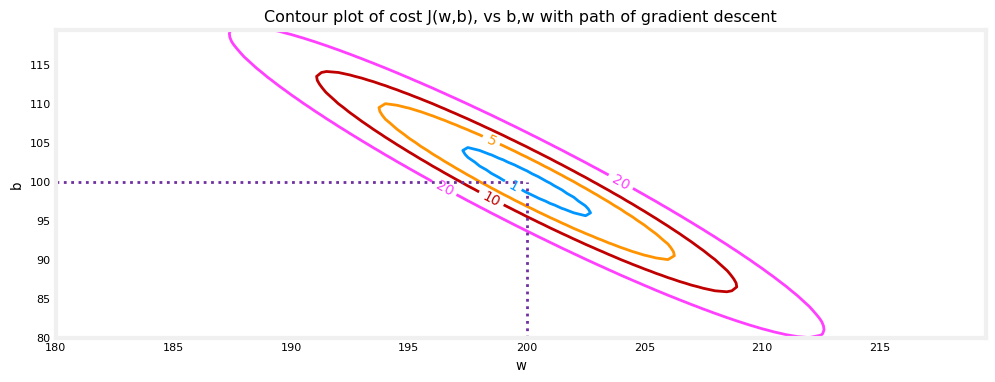

In [55]:
fig, ax = plt.subplots(1,1, figsize=(12, 4))
plt_contour_wgrad(x_train, y_train, p_hist, ax, w_range=[180, 220, 0.5], b_range=[80, 120, 0.5],
            contours=[1,5,10,20],resolution=0.5)


## Increased Learning Rate

In the lecture, there was a discussion related to the proper value of the learning rate, $\alpha$ in equation(3). The larger $\alpha$ is, the faster gradient descent will converge to a solution. But, if it is too large, gradient descent will diverge. Above you have an example of a solution which converges nicely.

Let's try increasing the value of $\alpha$ and see what happens:

In [56]:
# initialize parameters
w_init = 0
b_init = 0
# set alpha to a large value
iterations = 10
tmp_alpha = 8.0e-1
# run gradient descent
w_final, b_final, J_hist, p_hist = gradient_descent(x_train ,y_train, w_init, b_init, tmp_alpha, 
                                                    iterations, compute_cost, compute_gradient)
print(f"(w,b) found by gradient descent: ({w_final:8.4f},{b_final:8.4f})")

Iteration    0: Cost 2.58e+05  dj_dw: -6.500e+02, dj_db: -4.000e+02   w:  5.200e+02, b: 3.20000e+02
Iteration    1: Cost 7.82e+05  dj_dw:  1.130e+03, dj_db:  7.000e+02   w: -3.840e+02, b:-2.40000e+02
Iteration    2: Cost 2.37e+06  dj_dw: -1.970e+03, dj_db: -1.216e+03   w:  1.192e+03, b: 7.32800e+02
Iteration    3: Cost 7.19e+06  dj_dw:  3.429e+03, dj_db:  2.121e+03   w: -1.551e+03, b:-9.63840e+02
Iteration    4: Cost 2.18e+07  dj_dw: -5.974e+03, dj_db: -3.691e+03   w:  3.228e+03, b: 1.98886e+03
Iteration    5: Cost 6.62e+07  dj_dw:  1.040e+04, dj_db:  6.431e+03   w: -5.095e+03, b:-3.15579e+03
Iteration    6: Cost 2.01e+08  dj_dw: -1.812e+04, dj_db: -1.120e+04   w:  9.402e+03, b: 5.80237e+03
Iteration    7: Cost 6.09e+08  dj_dw:  3.156e+04, dj_db:  1.950e+04   w: -1.584e+04, b:-9.80139e+03
Iteration    8: Cost 1.85e+09  dj_dw: -5.496e+04, dj_db: -3.397e+04   w:  2.813e+04, b: 1.73730e+04
Iteration    9: Cost 5.60e+09  dj_dw:  9.572e+04, dj_db:  5.916e+04   w: -4.845e+04, b:-2.99567e+04


Above, $w$ and $b$ are bouncing back and forth between positive and negative with the absolute value increasing with each iteration. Further, each iteration $\frac{\partial J(w,b)}{\partial w}$ changes sign and cost is increasing rather than decreasing. This is a clear sign that the *learning rate is too large* and the solution is diverging. Let's visualize this with a plot.

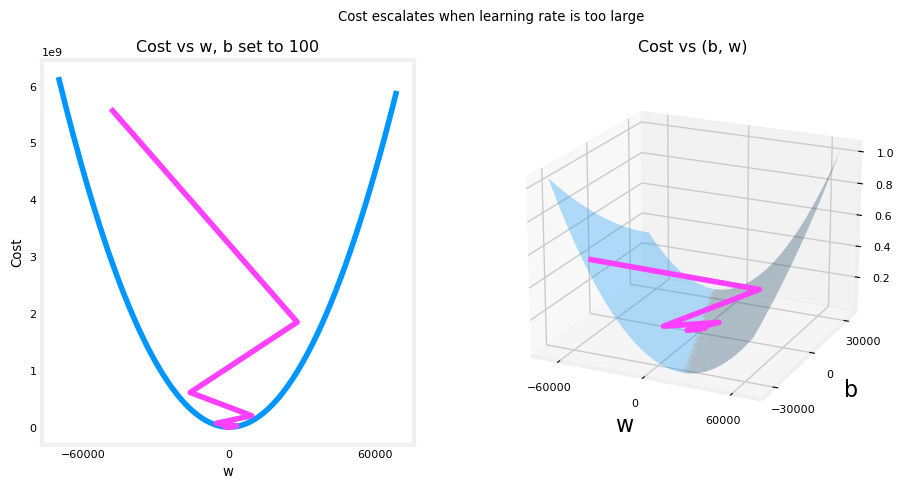

In [57]:
plt_divergence(p_hist, J_hist,x_train, y_train)
plt.show()

Above, the left graph shows $w$'s progression over the first few steps of gradient descent. $w$oscillates from positive to negative and cost grows rapidly. Gradient Descent is operating on both $w$ and $b$ simultaneously, so one needs the 3-D plot on the right for the complete picture.

## Congratulations!

In this lab you:

- delved into the details of gradient descent for a single variable.
- developed a routine to compute the gradient
- visualized what the gradient is
- completed a gradient descent routine
- utilized gradient descent to find parameters
- examined the impact of sizing the learning rate

